Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Classes: ['Acral_Lentiginous_Melanoma', 'Healthy_Nail', 'Onychogryphosis', 'blue_finger', 'clubbing', 'pitting']


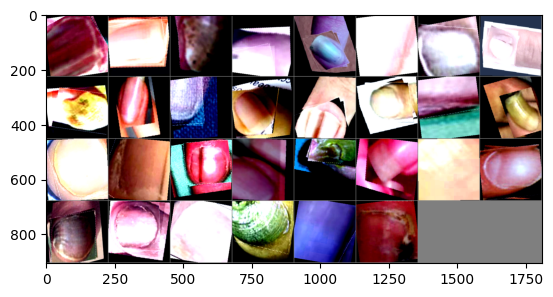

Onychogryphosis blue_finger clubbing clubbing blue_finger blue_finger blue_finger Acral_Lentiginous_Melanoma Onychogryphosis Healthy_Nail blue_finger Healthy_Nail Acral_Lentiginous_Melanoma clubbing clubbing Onychogryphosis pitting Acral_Lentiginous_Melanoma Acral_Lentiginous_Melanoma Healthy_Nail Onychogryphosis Healthy_Nail blue_finger clubbing clubbing pitting pitting Onychogryphosis blue_finger Acral_Lentiginous_Melanoma
Epoch 1/10: 
Train Loss: 1.0457, Train Accuracy: 0.5900
Val Loss: 0.3204, Val Accuracy: 0.8901
Epoch 2/10: 
Train Loss: 0.6437, Train Accuracy: 0.7580
Val Loss: 0.2613, Val Accuracy: 0.9121
Epoch 3/10: 
Train Loss: 0.5496, Train Accuracy: 0.7986
Val Loss: 0.1779, Val Accuracy: 0.9560
Epoch 4/10: 
Train Loss: 0.4826, Train Accuracy: 0.8365
Val Loss: 0.2014, Val Accuracy: 0.9341
Epoch 5/10: 
Train Loss: 0.4504, Train Accuracy: 0.8301
Val Loss: 0.1790, Val Accuracy: 0.9231
Epoch 6/10: 
Train Loss: 0.4187, Train Accuracy: 0.8451
Val Loss: 0.2023, Val Accuracy: 0.9121
E

In [ ]:
from google.colab import drive
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = 'PATH_TO_YOUR_TRAIN_DIR'
val_dir = 'PATH_TO_YOUR_VAL_DIR'

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)

batch_size = 30
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


class_names = train_dataset.classes
print("Classes:", class_names)


def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{class_names[labels[j]]}' for j in range(len(labels))))


model = models.mobilenet_v2(pretrained=True)


for param in model.features.parameters():
    param.requires_grad = True


num_classes = len(class_names)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.last_channel, num_classes)
)

model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

losses = []
train_accuracies = []
test_accuracies = []

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=15):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)

        losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)

        test_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}: ")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


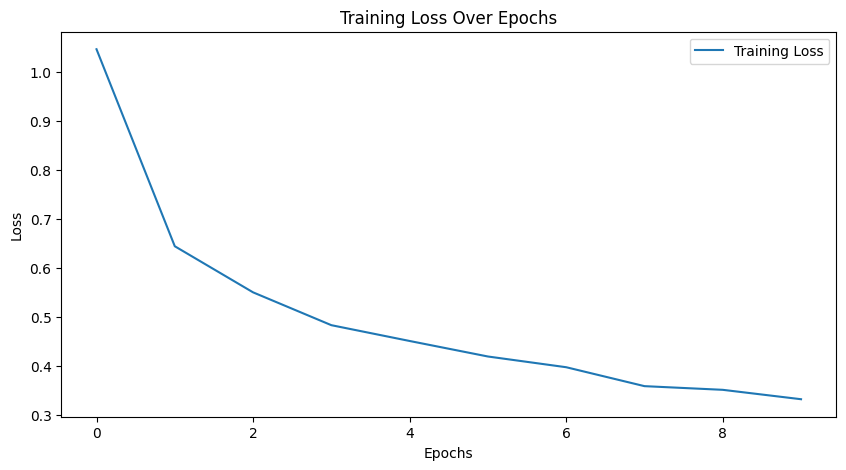

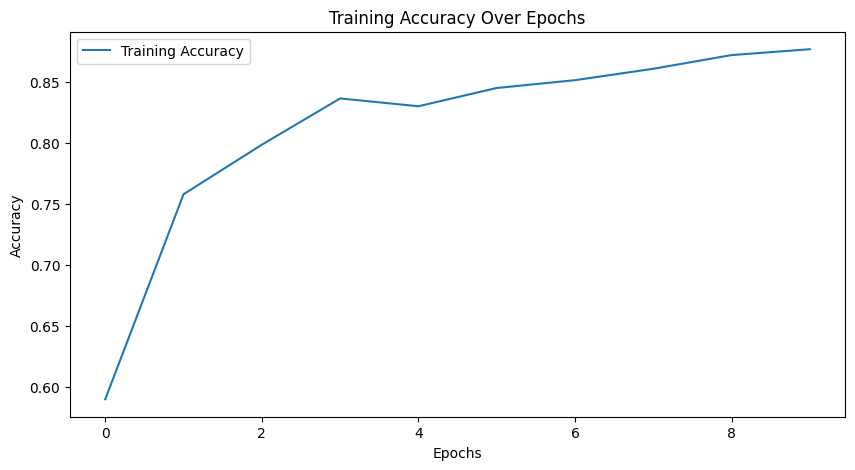

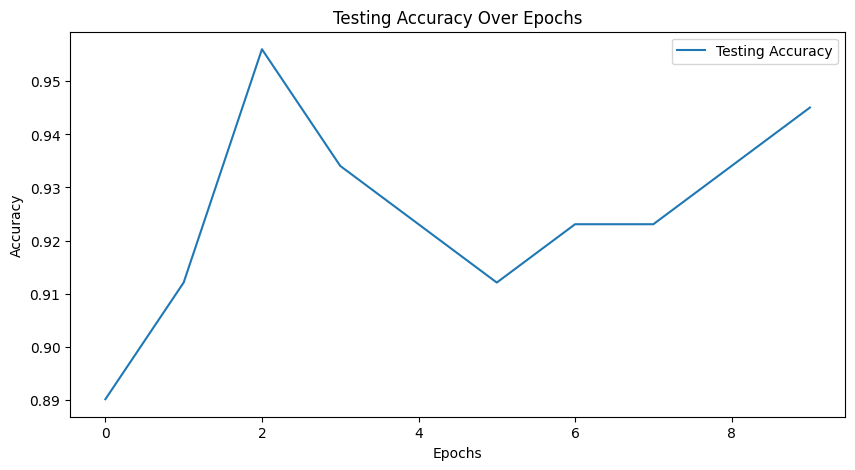

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy Over Epochs')
plt.legend()
plt.show()